In [7]:
import pandas as pd
import numpy as np
import seaborn as sns

# Ocultar warning de Keras y Tensorflow
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Input
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [8]:
df = pd.read_csv('LSTM-Multivariate_pollution.csv', parse_dates=['date'])

# Convertir a datetime format si no esta hecho
df['date'] = pd.to_datetime(df['date'])

# Fechas para graficar luego
train_dates = pd.to_datetime(df['date'])
df

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


<Axes: >

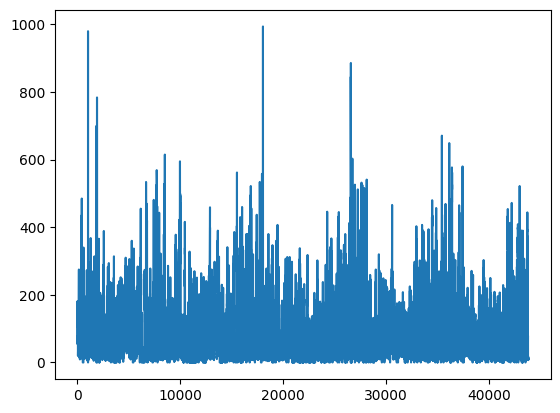

In [9]:
# Primer grafica de los datos de contaminacion
# Cantidad de particulas <= 2,5 micrometros por cada gramo/m3
pollution = df['pollution']
pollution.plot()

In [10]:
# Feature Engineering

wind_to_int = {
    'SE': 1,
    'NW': 2,
    'cv': 3,
    'NE': 4
}

df['wnd_dir'] = df['wnd_dir'].map(wind_to_int) 
df

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,1,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,1,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,1,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,1,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,2,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,2,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,2,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,2,246.72,0,0


In [11]:
# Entrenamiento

# Eliminamos las fechas del df ya que no son relevantes para el entrenamiento
df = df.drop(columns=['date'])

# Dividimos el set total en 80% entrenamiento y 20% validacion para hacer un modelo real
split = int(0.8 * len(df))

training_df = df[:split].astype(float)
val_df = df[split:].astype(float)                              

scaler = StandardScaler()
scaler = scaler.fit(training_df)
training_df_scaled = scaler.transform(training_df)
validated_df_scaled = scaler.transform(val_df)

n_future = 1
n_past = 48 * 5

def make_windows(scaled_dataset):
    X = []
    y = []
    for i in range(n_past, len(scaled_dataset) - n_future + 1):
        X.append(
            scaled_dataset[i - n_past : i, :]
        )
        y.append(
            scaled_dataset[i : i + n_future, 0]
        )
    return X, y
    
X_train, y_train = make_windows(training_df_scaled)
X_val, y_val = make_windows(validated_df_scaled)
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((34800, 240, 8), (34800, 1), (8520, 240, 8), (8520, 1))

In [12]:
# Modelo

model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(8, return_sequences=True))
model.add(LSTM(4, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 240, 8)         │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 4)              │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757 (2.96 KB)

 Trainable params: 757 (2.96 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Fit del modelo

hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=8, batch_size=8)

Epoch 1/8
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 162s 37ms/step - loss: 0.2246 - val_loss: 0.0795
Epoch 2/8
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 166s 38ms/step - loss: 0.1450 - val_loss: 0.0739
Epoch 3/8
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 166s 38ms/step - loss: 0.1435 - val_loss: 0.0828
Epoch 4/8
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 166s 38ms/step - loss: 0.1382 - val_loss: 0.0701
Epoch 5/8
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 166s 38ms/step - loss: 0.1395 - val_loss: 0.0747
Epoch 6/8
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 166s 38ms/step - loss: 0.1370 - val_loss: 0.0784
Epoch 7/8
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 166s 38ms/step - loss: 0.1363 - val_loss: 0.0749
Epoch 8/8
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 167s 38ms/step - loss: 0.1318 - val_loss: 0.0663


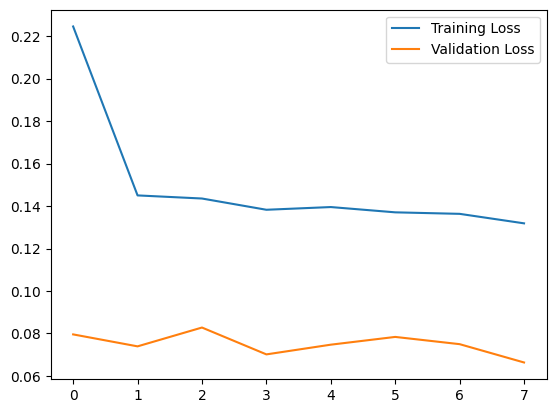

In [8]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()

In [9]:
# MSE Naive (Si el resultado es > al Validation Loss, mi modelo aporta valor real, si no, solo copia)
y_naive = X_val[:,-1, 0]
mse_naive = np.mean((y_naive - y_val.squeeze()) ** 2 )
mse_naive

0.07194308951048932

In [14]:
# Prediccion a 30 dias 
n_predict = 720 # 30 * 24
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_predict, freq='1h').tolist()

forecast = model.predict(X_train[-n_predict:])

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [27]:
# Inversion de escalamiento
forecast_copies = np.repeat(forecast, training_df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

# Agregamos las fechas que siguen

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date': np.array(forecast_dates), 'Pollution': y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Definimos la curva original para graficar
original_pollution = df[['date', 'pollution']].copy()
original_pollution['date'] = pd.to_datetime(original_pollution['date'])
original_pollution = original_pollution.loc[original_pollution['date'] >= '2014-09-30 19:00:00']

<Axes: xlabel='date', ylabel='pollution'>

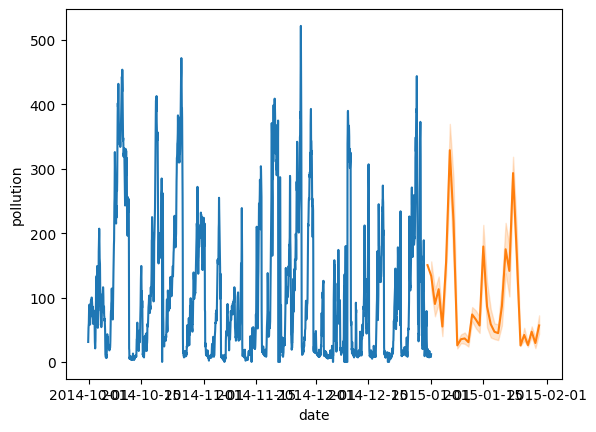

In [28]:
sns.lineplot(data=original_pollution, x='date', y='pollution')
sns.lineplot(data=df_forecast, x='Date', y='Pollution')